In [1]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [2]:
from matplotlib.pyplot import imread
from ffht import fht
from numpy.lib.scimath import sqrt as csqrt

In [3]:
seed(42)
n = 300
d = n
x = rand(d)
A = rand(n, d)
b = np.abs(A.dot(x))

In [4]:
def f(w, x, nu):
    return np.abs(w - b).sum() + 1/(2*nu)*norm(A.dot(x) - w)**2

def grad_g(w, nu):
    x_star = lstsq(A, w, rcond=None)[0]
    return 1/nu*(w - A.dot(x_star))

def prox_h(z, nu):
    y = ((abs(z) - b - nu).clip(0, None) - (-abs(z) + b - nu).clip(0, None) + b)
    return y*sign(z)

def pgd(f, grad, prox, w0, nu = 1, maxIter=1000, tol=1e-3):
    log = {"func_val_x" : [], "func_val_w" : []}
    w = w0
    w_prev = inf
    k = 0
    while (norm(w_prev-w) > tol) and k < maxIter:
        x = lstsq(A, w, rcond=None)[0]
        log["func_val_x"].append(f(w, x, nu))
        w_prev = w
        w = prox(A.dot(x), nu)
        log["func_val_w"].append(f(w, x, nu))
        k += 1
    return w, log

## Dummy test

In [5]:
w_star, log = pgd(f, grad_g, prox_h, A.dot(x + 0.1*rand(d)), nu=0.5, maxIter=40)

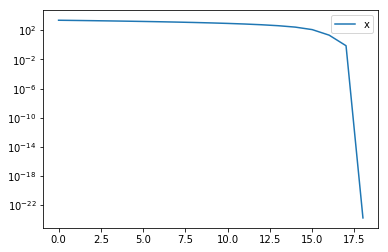

In [6]:
semilogy(log["func_val_x"], label="x")
legend()

## Real Grayscale Images 

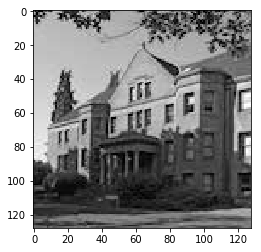

In [7]:
lewis = imread("lewis_grayscale_128.jpg")[:,:, 0]
imshow(lewis)
gray()

In [8]:
m, n = lewis.shape
lewis = lewis.reshape(m*n)

In [9]:
def corrupt(data, p=0.1):
    noise = rand(len(data)) > p
    return data * noise

In [16]:
corrupted_lewis = corrupt(lewis, p=0.95)

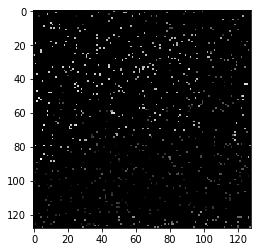

In [17]:
imshow(corrupted_lewis.reshape((m, n)))
gray()

In [18]:
def pad_to_power_of_two(arr, const=0):
    nextPower = np.ceil(np.log2((len(arr))))
    deficit = int(np.power(2, nextPower) - len(arr))
    return pad(arr, ((0, deficit)), 'constant'), deficit

#x, tail = pad_to_power_of_two(corrupted_lewis)

k = 4
seed(42)
S = rand(k, len(lewis))
S = (S > 0.5)*2-1

def Adot(x, k = k, S = S):
    m = len(x)
    result = zeros(k*m)
    for i, s in enumerate(S):
        result[i*m:i*m+m] = (s*x).astype(np.float32)
        fht(result[i*m:i*m+m])
    return result/sqrt(k*m)

def ATdot(w, k=k, S = S):
    result = zeros(int(len(w)/k))
    m = len(result)
    for i, s in enumerate(S):
        t = w[i*m:i*m+m]
        fht(t)
        result += s*t
    return result/sqrt(k*m)


b = np.abs(Adot(lewis))
w_star = Adot(lewis)
# D = zeros(k*len(x))
# D[:len(x)] = S[0]*S[1] + S[0]*S[2] + S[0]*S[3]
# D[len(x):2*len(x)] = S[1]*S[0] + S[1]*S[2] + S[1]*S[3]
# D[2*len(x):3*len(x)] = S[2]*S[0] + S[2]*S[1] + S[2]*S[3]
# D[3*len(x):] = S[3]*S[0] + S[3]*S[1] + S[3]*S[2]

In [19]:
def f(w, x, nu):
    return np.abs((np.abs(w) - b)).sum() + 1/(2*nu)*norm(Adot(x, k = k, S = S) - w)**2

def prox_h(z, nu):
    y = ((abs(z) - b - nu).clip(0, None) - (-abs(z) + b - nu).clip(0, None) + b)
    return y*sign(z)

def pgd(f, prox, w0, nu = 1, maxIter=2000, tol=1e-3):
    log = {"func_val" : [], "opt_cond" : []}
    w = w0
    c = 0
    iter_num = 0
    x = 0
    x_prev = 30
    w_prev = 30
    while (norm(x_prev-x) > tol) and iter_num < maxIter:
        x_prev = x
        x = ATdot(w, k = k, S = S)
        w = prox(Adot(x, k = k, S = S), nu)
        log["opt_cond"].append(norm(x_prev - x))
        f_val = f(w, x, nu)
        log["func_val"].append(f_val)
        iter_num += 1
    return w, log

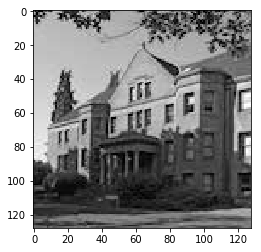

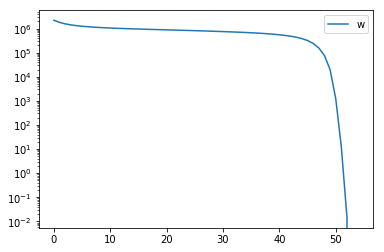

In [20]:
x0 = corrupted_lewis
w0 = Adot(x0)
nu = 20
f_min = f(w_star, lewis, nu)
w_pred, log = pgd(f, prox_h, w0 = w0, nu = nu, tol=1e-3)
x_pred = ATdot(w_pred).reshape((m, n))
imshow(x_pred)
show()
semilogy(array(log["func_val"]), label="w")
legend()

[]

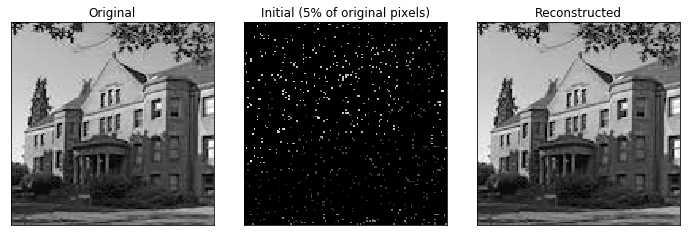

In [21]:
fig = figure(figsize=(12,4))
grid = plt.GridSpec(1, 3, wspace=0.15, hspace=0.15)
orig = fig.add_subplot(grid[0, 0])
orig.imshow(lewis.reshape((m,n)))
orig.set_title("Original")
orig.set_xticks([])
orig.set_yticks([])
corrupted = fig.add_subplot(grid[0, 1])
corrupted.imshow(corrupted_lewis.reshape((m,n)))
corrupted.set_title("Initial (5% of original pixels)")
corrupted.set_xticks([])
corrupted.set_yticks([])
reconstructed = fig.add_subplot(grid[0, 2])
reconstructed.imshow(x_pred)
reconstructed.set_title("Reconstructed")
reconstructed.set_xticks([])
reconstructed.set_yticks([])

## Real Color Image

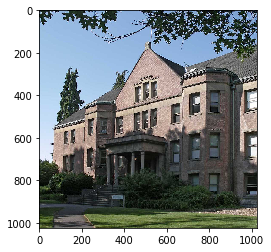

In [86]:
lewis = imread("lewis.jpeg")
imshow(lewis)
gray()

In [87]:
m, n, d = lewis.shape
lewis = lewis.reshape(m*n*d)

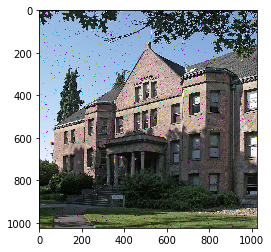

In [88]:
corrupted_lewis = corrupt(lewis, p=0.01)
imshow(corrupted_lewis.reshape((m, n, d)))

In [93]:
def pad_to_power_of_two(arr, const=0):
    nextPower = np.ceil(np.log2((len(arr))))
    deficit = int(np.power(2, nextPower) - len(arr))
    return pad(arr, ((0, deficit)), 'reflect'), deficit

corrupted_lewis_ext, tail = pad_to_power_of_two(corrupted_lewis)
lewis_ext, tail = pad_to_power_of_two(lewis)

seed(42)
k = 4
S = rand(k, len(corrupted_lewis_ext))
S = (S > 0.5)*2-1
b = np.abs(Adot(corrupted_lewis_ext, k = k, S = S))
w0 = Adot(corrupted_lewis_ext, k = k, S = S)
nu = 0.5
w_star = Adot(lewis_ext, k = k, S = S)
#f_min = f(w_star, lewis_ext, nu)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


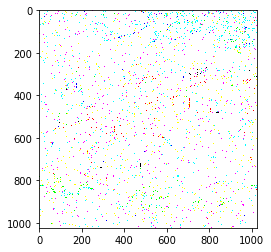

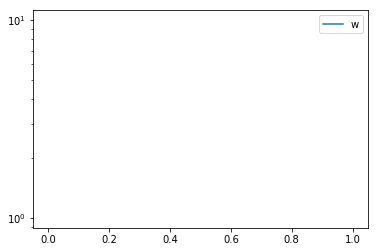

In [95]:
w_pred, log = pgd(f, grad_g, prox_h, w0 = w0, nu = nu, tol=1e-3)
x_pred = (ATdot(w_pred, k = k, S = S)[:-tail]).reshape((m, n, d))
imshow(x_pred)
show()
semilogy(array(log["func_val"]), label="w")
legend()

## Semi-quadratic loss

In [45]:
lewis = imread("lewis_grayscale_128.jpg")[:,:, 0]
m, n = lewis.shape
lewis = lewis.reshape(m*n)
corrupted_lewis = corrupt(lewis, p=0.1)

k = 4
seed(42)
S = rand(k, len(lewis))
S = (S > 0.5)*2-1

def Adot(x, k = k, S = S):
    m = len(x)
    result = zeros(k*m)
    for i, s in enumerate(S):
        result[i*m:i*m+m] = (s*x).astype(np.float32)
        fht(result[i*m:i*m+m])
    return result/sqrt(k*m)

def ATdot(w, k=k, S = S):
    result = zeros(int(len(w)/k))
    m = len(result)
    for i, s in enumerate(S):
        t = w[i*m:i*m+m]
        fht(t)
        result += s*t
    return result/sqrt(k*m)


b = np.abs(Adot(lewis))
w_star = Adot(lewis)
xs_trajectory = []


def f(w, x, z, nu, lam):
    A = np.abs((np.abs(z) - b**2)).sum()
    B = 1/(2*nu)*norm(Adot(x, k = k, S = S) - w)**2
    C = 1/(2*lam)*norm(w**2 - z)**2
    print(A, B, C, A+B+C)
    return np.abs((np.abs(z) - b**2)).sum() + 1/(2*nu)*norm(Adot(x, k = k, S = S) - w)**2 + 1/(2*lam)*norm(w**2 - z)**2

def prox_h(z, nu):
    y = ((abs(z) - b**2 - nu).clip(0, None) - (-abs(z) + b**2 - nu).clip(0, None) + b**2)
    return y*sign(z)

def prox_phi(z, x, nu, lam, y=None):
    w = zeros(len(z))
    y = Adot(x)
    for i, (zi, yi) in enumerate(zip(z, y)):
        c = np.poly1d([1/(2*lam),0,- (zi/lam - 1/(2*nu)),- yi/nu,(zi**2/(2*lam) + (yi)**2/(2*nu))])
        d = np.poly1d([1, 0, -(zi - lam/(2*nu)), -lam*yi/(2*nu)])
        d2 = np.poly1d([3, 0, -(zi - lam/(2*nu))])
        crit = d.r
        r_crit = crit[crit.imag==0].real
        test = d2(r_crit) 
        x_min = r_crit[test>0]
        w[i] = x_min[argmin(c(x_min))]
        
#         v = zi - lam/(2*nu)
#         u = lam*yi/(2*nu)
#         w_alt = (2./3.)**(1./3.)*v/(sqrt(3)*sqrt(27*u**2 - 4*v**3) + 9*u)**(1./3.) + (sqrt(3)*sqrt(27*u**2 - 4*v**3) + 9*u)**(1./3.)/((2)**(1./3.)*3**(2./3.))
#         w[i] = w_alt
#        if i % 100000 == 0:
#            print(i)
        
#        plot(w[i], c(w[i]), 'o')
#        t_span = linspace(-2, 2, 100)
#        plot(t_span, c(t_span))
#        show()
#     v = z - lam/(2*nu)
#     u = lam*y/(2*nu)
#     w_alt = (2./3.)**(1./3.)*v/(sqrt(3)*csqrt(27*u**2 - 4*v**3) + 9*u)**(1./3.) + (sqrt(3)*csqrt(27*u**2 - 4*v**3) + 9*u)**(1./3.)/((2)**(1./3.)*3**(2./3.))
#     w = w_alt
    return w

def pgd2(w0, nu = 1, lam=1, maxIter=2000, tol=1e-3):
    log = {"func_val" : [], "opt_cond" : []}
    w = w0
    z = w0**2
    c = 0
    iter_num = 0
    x = 0
    x_prev = 30
    w_prev = 30
    z_prev = 30
    
    while iter_num < maxIter:# and (norm(x_prev-x) > tol):
        print(iter_num)
        x_prev = x
        x = ATdot(w, k = k, S = S)
        w = prox_phi(z, x, nu, lam)
        z = prox_h(w**2, lam)
        log["opt_cond"].append(norm(x_prev - x))
        f_val = f(w, x, z, nu, lam)
        log["func_val"].append(f_val)
        iter_num += 1
        xs_trajectory.append(x)
        #print(f_val)
    return w, log

0
102203445.28083801 3.8841131564410807e-25 640913.2874926922 102844358.5683307
1
100951240.86716732 1123.312574263296 624382.5396424182 101576746.71938401
2
99728528.85383283 2294.239034844596 609955.2262570475 100340778.31912471
3
98532060.97823139 3819.2671689601457 597043.568344585 99132923.81374492
4
97360135.52735089 5505.701693170802 585126.1998935699 97950767.42893763
5
96210116.5605021 7289.724037501852 574230.4908125286 96791636.77535212
6
95081309.18575847 9162.436958930219 563810.675794082 95654282.29851148
7
93972995.46269946 11086.24125697274 553595.6183832338 94537677.32233965
8
92883987.78045875 13019.694454332135 544053.3735796858 93441060.84849276
9
91813582.62639554 14957.42456378548 534763.6027545301 92363303.65371385
10
90761068.0079557 16879.64881172558 525949.9010377984 91303897.55780523
11
89725777.61076954 18779.530098525396 517348.4351280867 90261905.57599616
12
88707306.84608829 20665.699743653313 508964.78418038966 89236937.33001234
13
87705386.3726098 22505

33313923.9079175 42966.247257716735 159901.85853279315 33516792.01370801
109
32996619.89324284 42209.99991136714 158398.67033128615 33197228.563485492
110
32682794.635119285 41535.867053613045 156616.8143154253 32880947.316488326
111
32372549.03861091 40938.236359487724 154849.77512475927 32568337.050095156
112
32065530.425171968 40391.97145592442 153218.90512021128 32259141.301748104
113
31762035.32820602 39829.74430661058 151470.27953822265 31953335.352050852
114
31461631.73650184 39395.273414992844 149934.29084882347 31650961.300765656
115
31164373.987782005 38923.66743688414 148372.1298105927 31351669.785029482
116
30869975.634520173 38483.89558276437 146908.2770901577 31055367.807193097
117
30578604.193663396 37991.09497519019 145436.50694108644 30762031.79557967
118
30290115.049970124 37457.68106939768 143976.65571378928 30471549.38675331
119
30004691.046989094 37067.702332328234 142430.1602223793 30184188.9095438
120
29722451.626234926 36650.61059558674 140810.16257451463 298999

12718817.816555813 14729.232798684849 56405.127600760585 12789952.176955258
214
12606754.944307206 14583.179641731082 55891.50601175198 12677229.62996069
215
12495958.863617359 14448.003755825885 55251.42919479576 12565658.29656798
216
12386145.98590159 14312.15185764441 54783.44566788338 12455241.583427118
217
12277255.645467538 14168.118074075212 54333.149384899756 12345756.912926512
218
12169217.728957517 14023.269870605021 53904.123161398296 12237145.12198952
219
12062137.146259965 13885.127168083334 53407.73682487387 12129430.010252923
220
11956000.578544656 13748.985421547732 52946.81141103376 12022696.375377238
221
11850826.691858858 13617.093010714514 52457.7134962331 11916901.498365805
222
11746612.61984235 13485.652902463204 51995.1526069639 11812093.425351778
223
11643430.421904948 13351.395125150137 51428.78319034568 11708210.600220444
224
11541618.519894179 13215.858601207256 50751.82045852521 11605586.198953912
225
11441102.977880893 13084.117778608845 50111.1622271572 11

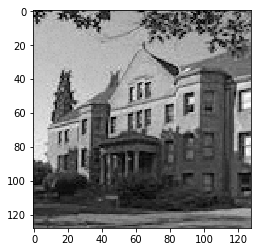

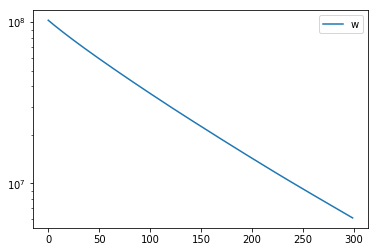

In [46]:
x0 = corrupted_lewis
w0 = Adot(x0)
z0 = w0**2
nu = 20
lam = 20
w_pred, log = pgd2(w0, lam = lam, nu = nu, maxIter=300, tol=1e-3)
x_pred =  ATdot(w_pred).reshape((m, n))
imshow(x_pred)
show()
semilogy(array(log["func_val"]), label="w")
legend()

0


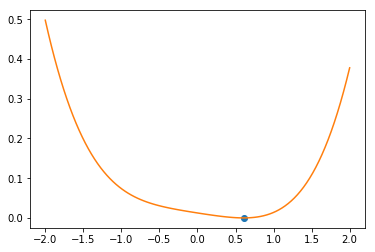

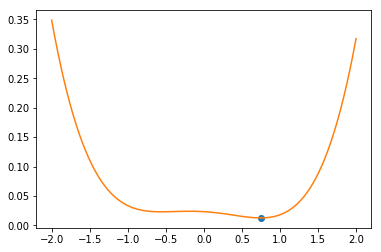

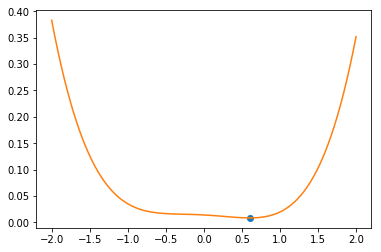

In [93]:
seed(42)
z = rand(3)
y = rand(3)
w = prox_phi(z, y, lam, nu)

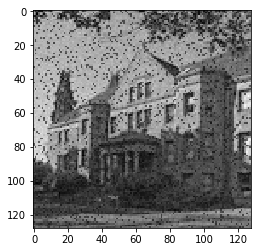

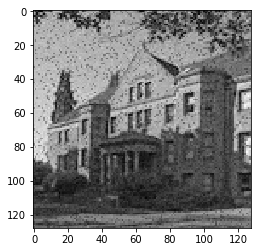

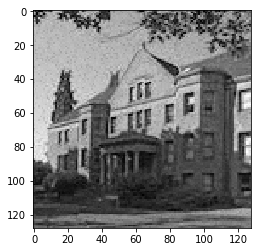

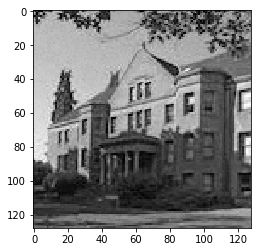

In [53]:
x_pred =  xs_trajectory[50].reshape((m, n))
imshow(x_pred)
show()
x_pred =  xs_trajectory[100].reshape((m, n))
imshow(x_pred)
show()
x_pred =  xs_trajectory[200].reshape((m, n))
imshow(x_pred)
show()
x_pred =  xs_trajectory[-1].reshape((m, n))
imshow(x_pred)
show()

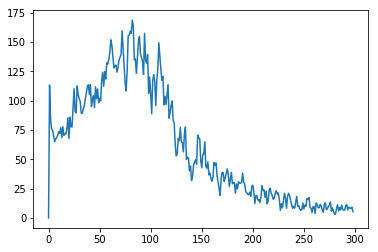

In [64]:
plot([norm(y - x) for x, y in zip(xs_trajectory[:-1], xs_trajectory[1:])])

## Quadratic loss

90% of pixels

In [71]:
lewis = imread("lewis_grayscale_128.jpg")[:,:, 0]
m, n = lewis.shape
lewis = lewis.reshape(m*n)
corrupted_lewis = corrupt(lewis, p=0.9)

k = 4
seed(42)
S = rand(k, len(lewis))
S = (S > 0.5)*2-1

def Adot(x, k = k, S = S):
    m = len(x)
    result = zeros(k*m)
    for i, s in enumerate(S):
        result[i*m:i*m+m] = (s*x).astype(np.float32)
        fht(result[i*m:i*m+m])
    return result/sqrt(k*m)

def ATdot(w, k=k, S = S):
    result = zeros(int(len(w)/k))
    m = len(result)
    for i, s in enumerate(S):
        t = w[i*m:i*m+m]
        fht(t)
        result += s*t
    return result/sqrt(k*m)


b = np.abs(Adot(lewis))
w_star = Adot(lewis)
xs_trajectory = []


def f(w, x, lam):
    B = 1/(2*lam)*norm(Adot(x, k = k, S = S) - w)**2
    C = norm(w**2 - b**2)**2
    print(B, C, B+C)
    return B+C

def prox_phi(x, lam, y=None):
    y = Adot(x)
    w = zeros(len(y))
    z = b**2
    for i, (zi, yi) in enumerate(zip(z, y)):
        c = np.poly1d([1/(2*lam),0,- (zi/lam - 1/(2*nu)),- yi/nu,(zi**2/(2*lam) + (yi)**2/(2*nu))])
        d = np.poly1d([1, 0, -(zi - lam/(2*nu)), -lam*yi/(2*nu)])
        d2 = np.poly1d([3, 0, -(zi - lam/(2*nu))])
        crit = d.r
        r_crit = crit[crit.imag==0].real
        test = d2(r_crit) 
        x_min = r_crit[test>0]
        w[i] = x_min[argmin(c(x_min))]
    return w

def pgd3(w0, lam=1, maxIter=2000, tol=1e-3):
    log = {"func_val" : [], "opt_cond" : []}
    w = w0
    iter_num = 0
    x = 0
    x_prev = 30
    w_prev = 30
    
    while iter_num < maxIter and (norm(x_prev-x) > tol) or iter_num < 3:# and (norm(x_prev-x) > tol):
        print(iter_num)
        x_prev = x
        x = ATdot(w, k = k, S = S)
        w = prox_phi(x, lam)
        log["opt_cond"].append(norm(x_prev - x))
        f_val = f(w, x, lam)
        log["func_val"].append(f_val)
        iter_num += 1
        xs_trajectory.append(x)
        #print(f_val)
    return w, log

In [72]:
x0 = corrupted_lewis
w0 = Adot(x0)
lam = 20
w_pred, log = pgd3(w0, lam = lam, maxIter=2000, tol=1e-6)
x_pred =  ATdot(w_pred).reshape((m, n))
imshow(x_pred)
show()
semilogy(array(log["func_val"]), label="w")
legend()

0
4552737.906722504 41745.664143353555 4594483.570865857
1
2346125.0953329243 111896.6182858343 2458021.7136187586
2
1953963.2523460258 103223.28377333135 2057186.5361193572
3
1800877.1592587319 99664.28468687974 1900541.4439456116
4
1723932.1035484136 97312.94918935772 1821245.0527377713
5
1686544.1613240198 95976.4361815146 1782520.5975055343
6
1667776.7652142225 95562.71319466362 1763339.4784088861
7
1655321.8883768052 95170.15904052959 1750492.0474173347
8
1646672.519894927 94893.21709145633 1741565.7369863833
9
1640325.9141916225 94731.23289725606 1735057.1470888786
10
1636132.4216863257 94615.92439122735 1730748.346077553
11
1631849.815956961 94315.26706580808 1726165.083022769
12
1629262.1827400017 94140.21344533804 1723402.3961853397
13
1626738.2255998044 94112.58213810042 1720850.8077379048
14
1624421.209813562 93987.96684041087 1718409.1766539728
15
1623053.0682147113 93916.10823090916 1716969.1764456204
16
1622232.8007142192 93855.75225334153 1716088.5529675607
17
1621499.16

KeyboardInterrupt: 

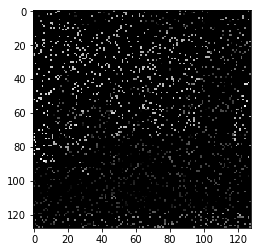

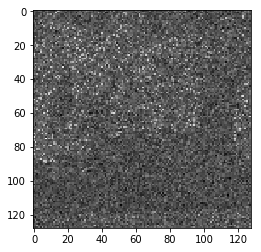

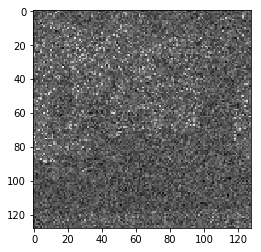

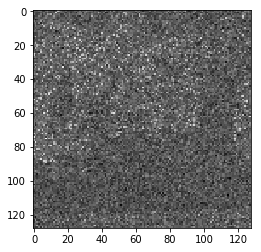

In [74]:
x_pred =  xs_trajectory[0].reshape((m, n))
imshow(x_pred)
show()
x_pred =  xs_trajectory[5].reshape((m, n))
imshow(x_pred)
show()
x_pred =  xs_trajectory[20].reshape((m, n))
imshow(x_pred)
show()
x_pred =  xs_trajectory[-1].reshape((m, n))
imshow(x_pred)
show()

50% of pixels

In [75]:
lewis = imread("lewis_grayscale_128.jpg")[:,:, 0]
m, n = lewis.shape
lewis = lewis.reshape(m*n)
corrupted_lewis = corrupt(lewis, p=0.5)

k = 4
seed(42)
S = rand(k, len(lewis))
S = (S > 0.5)*2-1

def Adot(x, k = k, S = S):
    m = len(x)
    result = zeros(k*m)
    for i, s in enumerate(S):
        result[i*m:i*m+m] = (s*x).astype(np.float32)
        fht(result[i*m:i*m+m])
    return result/sqrt(k*m)

def ATdot(w, k=k, S = S):
    result = zeros(int(len(w)/k))
    m = len(result)
    for i, s in enumerate(S):
        t = w[i*m:i*m+m]
        fht(t)
        result += s*t
    return result/sqrt(k*m)


b = np.abs(Adot(lewis))
w_star = Adot(lewis)
xs_trajectory = []


def f(w, x, lam):
    B = 1/(2*lam)*norm(Adot(x, k = k, S = S) - w)**2
    C = norm(w**2 - b**2)**2
    print(B, C, B+C)
    return B+C

def prox_phi(x, lam, y=None):
    y = Adot(x)
    w = zeros(len(y))
    z = b**2
    for i, (zi, yi) in enumerate(zip(z, y)):
        c = np.poly1d([1/(2*lam),0,- (zi/lam - 1/(2*nu)),- yi/nu,(zi**2/(2*lam) + (yi)**2/(2*nu))])
        d = np.poly1d([1, 0, -(zi - lam/(2*nu)), -lam*yi/(2*nu)])
        d2 = np.poly1d([3, 0, -(zi - lam/(2*nu))])
        crit = d.r
        r_crit = crit[crit.imag==0].real
        test = d2(r_crit) 
        x_min = r_crit[test>0]
        w[i] = x_min[argmin(c(x_min))]
    return w

def pgd3(w0, lam=1, maxIter=2000, tol=1e-3):
    log = {"func_val" : [], "opt_cond" : []}
    w = w0
    iter_num = 0
    x = 0
    x_prev = 30
    w_prev = 30
    
    while iter_num < maxIter and (norm(x_prev-x) > tol) or iter_num < 3:# and (norm(x_prev-x) > tol):
        print(iter_num)
        x_prev = x
        x = ATdot(w, k = k, S = S)
        w = prox_phi(x, lam)
        log["opt_cond"].append(norm(x_prev - x))
        f_val = f(w, x, lam)
        log["func_val"].append(f_val)
        iter_num += 1
        xs_trajectory.append(x)
        #print(f_val)
    return w, log

0
2406722.746822609 94696.91701339869 2501419.663836008
1
872067.7610952356 45435.004540590955 917502.7656358265
2
456548.20522883994 24285.55775348448 480833.7629823244
3
260750.9693875475 14131.47675132268 274882.44613887015
4
125003.85335339583 7197.441986931921 132201.29534032775
5
35955.586112721525 2537.672399732852 38493.25851245438
6
3451.0580620574874 483.2061944821146 3934.264256539602
7
62.22108692627836 41.007176101637064 103.22826302791543
8
0.20335473499770887 0.5212703529584202 0.724625087956129
9
0.0066604030574740295 0.01518150465605095 0.02184190771352498
10
0.00031657991343280936 0.000612550514016237 0.0009291304274490464
11
1.77829803927484e-05 2.9841815502717816e-05 4.7624795895466215e-05
12
1.0975243681644751e-06 1.6376857014543918e-06 2.735210069618867e-06
13
7.556649352294725e-08 9.922584900296589e-08 1.7479234252591314e-07
14
5.901153907107519e-09 4.628461838457126e-09 1.0529615745564646e-08
15
7.454424298576662e-11 2.0015042786943933e-11 9.455928577271055e-11


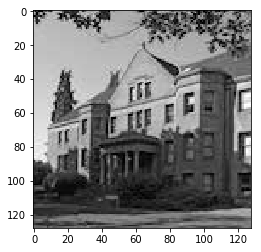

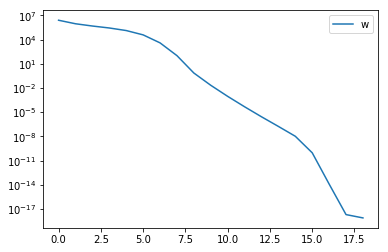

In [76]:
x0 = corrupted_lewis
w0 = Adot(x0)
lam = 20
w_pred, log = pgd3(w0, lam = lam, maxIter=2000, tol=1e-6)
x_pred =  ATdot(w_pred).reshape((m, n))
imshow(x_pred)
show()
semilogy(array(log["func_val"]), label="w")
legend()

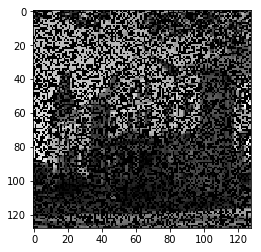

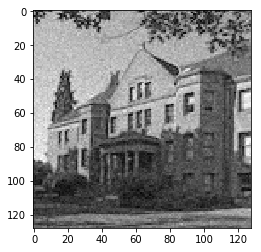

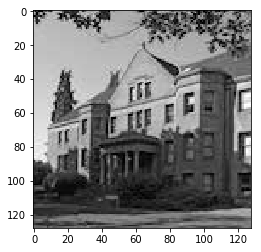

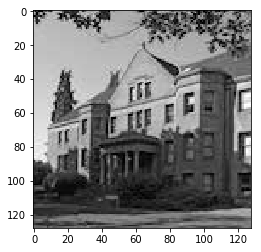

In [78]:
x_pred =  xs_trajectory[0].reshape((m, n))
imshow(x_pred)
show()
x_pred =  xs_trajectory[5].reshape((m, n))
imshow(x_pred)
show()
x_pred =  xs_trajectory[10].reshape((m, n))
imshow(x_pred)
show()
x_pred =  xs_trajectory[-1].reshape((m, n))
imshow(x_pred)
show()